### Case Study - Pinchout and Fault Scenarios
#### Showcasing LoopStructural-Flopy to address Model Structure Uncertainty

This notebook showcases how structural parameters, in this case CPz and fault_offset can be used to generate multiple structural models and address structural uncertainty in 3D groundwater models. This notebook contains the Pinchout and Fault Scenarios and use a synthetic example to explore uncertainty in pinchout location and fault geometry. 

In [12]:
import pandas as pd
import numpy as np
import math
import subprocess
import sys
import os
import pickle
import functions # This is a project specific python script saved in folder functions.py
    
%run ./figures.ipynb                   # Contains functions to produce figures

%load_ext autoreload
%autoreload 2
logfunc = lambda e: np.log10(e)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
from loop2flopy import Project
P = Project('showcase', boundingbox = [0, 6000, 0, 6000, -500, 0]) # (x0, x1, y0, y1, z0, z1)

# Spatial information
P.crs = "epsg:28350" # Put in coordinate reference
P.xypumpbores = []#(500,500), (1600, 2800), (5500,5500), (2800,1600)] 
P.npump = len(P.xypumpbores)
P.idpumpbores = [] 
P.xyobsbores = [(1500,1000), (2500, 5000), (4000, 3000), (5000,1500)]
P.idobsbores = ['OB1', 'OB2', 'OB3', 'OB4'] 
#P.geo_coords=[(500,500), (1600, 2800), (5500,5500), (2800,1600)]
#P.geo_bores = ['P1', 'P2', 'P3', 'P4']

# Observation Points
P.nobs = len(P.xyobsbores)
obs_z = [-40, -50, -100, -200, -300]
P.nzobs = len(obs_z)
P.zobs = np.ones((P.nobs, P.nzobs))
for j in range(P.nzobs):
    P.zobs[:, j] = P.zobs[:, j] * obs_z[j] 

# Meshing parameters
P.triExeName = '../exe/triangle.exe'
P.fx1, P.fy1, P.fx2, P.fy2 = (2000, 4500, 3000, 1000) # fault end points
P.fault_buffer = 150.  # offset boundary from fault
P.r = 40               # refining factor for model boundary. High r has refined edges
P.w = 100              # interior boundary offset
P.boundmaxtri = 50000  # max triangle area in boundary area
P.modelmaxtri = 50000  # max triangle area in main model area
P.angle = 34           # minimum triangle angles
P.radius1 = 100        # radius of inner circle around pumping bores
P.radius2 = 200        # radius of outer circle around pumping bores
P.boremaxtri = 100000   # max triangle area within bore radius

# Flow model parameters
P.mfexe_name = '../exe/mf6.exe'
P.workspace = '../modelfiles/'
P.nlg = 4    # number of geological layers
P.nls = 2    # number sublayers for conformable
P.nlv  = 30  # number of layers for voxel transect grid
P.res = 2    # vertical resolution upon which voxel grid created to pick lithology bottoms

P.ss = [0.00009, 0.00007, 0.00002, 0.00008]
P.sy = [0.12, 0.1, 0.1, 0.1]

P.rch = 0.4/365 # 0.0027 m/d
P.strt = -20.
P.chfunc = lambda x,z: -(0.005*x) - (z * 0.02)-20 # horizontal gradient of 0.01 and vertical gradient of 0.02
P.xt3d = True
   
vtk_workspace = '../vtk_files'
if not os.path.isdir(vtk_workspace):
    os.makedirs(vtk_workspace, exist_ok=True)
    
if not os.path.isdir('../modelfiles'):
    os.makedirs(P.workspace, exist_ok=True)

In [14]:
from meshing_routines import createcell2d
P.obs_ref = 150
P.cell2dtri, P.xcyctri, P.verticestri, P.tri, trinodes = createcell2d(P, grid = 'tri', fault = True)  
P.cell2dvor, P.xcycvor, P.verticesvor, P.vor, vornodes = createcell2d(P, grid = 'vor', fault = True)  

[(100, 100), (5900, 100), (5900, 5900), (100, 5900)]


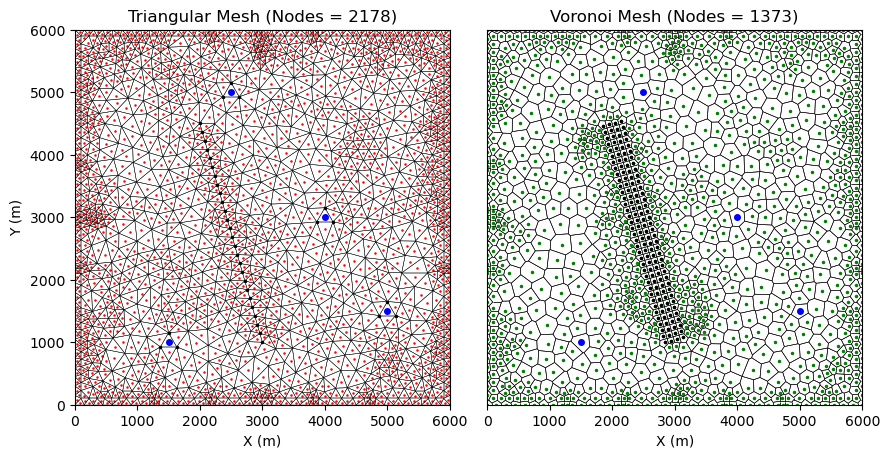

In [15]:
figure3(P)

### Faults - 6 simulations

In [5]:
P.hk = [1, 2, 0.01, 5] 
P.vk = [i/10 for i in P.hk]

options = [0,50,120,150,200,250] # Fault displacement

data = pd.read_excel("../data/loop_showcase_data.xls",sheet_name = "fault_example")
strat = pd.read_excel("../data/loop_showcase_data.xls",sheet_name = "strat")

P.control_points = ([])
P.fault_max_disp = 100.    # Was 200
P.minor_axis = 1000        # Fault_influence - orthogonal to fault
P.fault_center = [P.fx1 + (P.fx2 - P.fx1)/2, P.fy1 + (P.fy2 - P.fy1)/2, -400]
P.fault_slip_vector=[0,0,1]
    
fault_modelnames, fault_models, fault_obs_heads = [],[],[]         

from loop2flopy import Model
for i in range(len(options)):
    fault_modelnames.append(str('FD_'+str(options[i])))  
    fault_models.append(Model(fault_modelnames[i], P, plan = 'vor', transect = 'con')) # Create flow model  
    P.fault_max_disp = options[i] 
    P.data, P.strat = functions.prepare_geomodel_loopshowcase(P, data, strat, include_fault = True)   # Prepare geomodel inputs
    P.geomodel = functions.create_geomodel_loopshowcase(P, include_fault = True) # Make geomodel
    M = fault_models[i]
    M.create_lith_dis_arrays(P)                                 # Create lith and dis arrays
    M.create_prop_arrays(P)                                     # Create K arrays
    M.create_flow_package_arrays(P)                             # Create flow packages
    results = M.write_run_model(P, period = 'Steady', ic_array = P.strt) 
    M.gwf, M.head_ss, M.obs_ss, M.runtime_ss = results[0], results[1], results[2], results[-1]
    fault_obs_heads.append((functions.process_obs_steady(P, M)))
    f = os.path.join(vtk_workspace, "faults", M.modelname)
    M.gwf.export(f, fmt="vtk")

                          projected onto fault surface estimating from fault normal
C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Fault included!
   Creating lithology and discretisation arrays for  FD_0  ...
   Creating property arrays for  FD_0  ...
Modelling routines loaded!
   Adding flow packages to  FD_0  ...
   Time taken =  0.932872
   Writing simulation and gwf for  FD_0  ...
Period =  Steady 
   Model success =  True
   run_time =  10.387359


                          projected onto fault surface estimating from fault normal
C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Fault included!
   Creating lithology and discretisation arrays for  FD_50  ...
   Creating property arrays for  FD_50  ...
   Adding flow packages to  FD_50  ...
   Time taken =  0.76243
   Writing simulation and gwf for  FD_50  ...
Period =  Steady 
   Model success =  True
   run_time =  11.110303


                          projected onto fault surface estimating from fault normal
C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Fault included!
   Creating lithology and discretisation arrays for  FD_120  ...
   Creating property arrays for  FD_120  ...
   Adding flow packages to  FD_120  ...
   Time taken =  0.741561
   Writing simulation and gwf for  FD_120  ...
Period =  Steady 
   Model success =  True
   run_time =  10.09622


                          projected onto fault surface estimating from fault normal
C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Fault included!
   Creating lithology and discretisation arrays for  FD_150  ...
   Creating property arrays for  FD_150  ...
   Adding flow packages to  FD_150  ...
   Time taken =  1.20535
   Writing simulation and gwf for  FD_150  ...
Period =  Steady 
   Model success =  True
   run_time =  18.50254


                          projected onto fault surface estimating from fault normal
C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Fault included!
   Creating lithology and discretisation arrays for  FD_200  ...
   Creating property arrays for  FD_200  ...
   Adding flow packages to  FD_200  ...
   Time taken =  1.001815
   Writing simulation and gwf for  FD_200  ...
Period =  Steady 
   Model success =  True
   run_time =  14.170118


                          projected onto fault surface estimating from fault normal
C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Fault included!
   Creating lithology and discretisation arrays for  FD_250  ...
   Creating property arrays for  FD_250  ...
   Adding flow packages to  FD_250  ...
   Time taken =  1.070797
   Writing simulation and gwf for  FD_250  ...
Period =  Steady 
   Model success =  True
   run_time =  15.030126


In [6]:
# PLOTS
#plot_bores(P)
#plot_observations(heads = fault_obs_heads, modelnames = fault_modelnames, ylim = [-40, -5])
#plot_bylayer(P, models = fault_models, layer = 2, vmin = -35, vmax = -10) 
#multiplot_vgrid_transect(P, models = fault_models, array = 'lith', X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1)
#multiplot_prop_transect(P, models = fault_models, array = 'head_ss', X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1,)

C:\Users\19904604\AppData\Local\Temp\ipykernel_28160\3735542499.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
C:\Users\19904604\AppData\Local\Temp\ipykernel_28160\3735542499.py:123: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


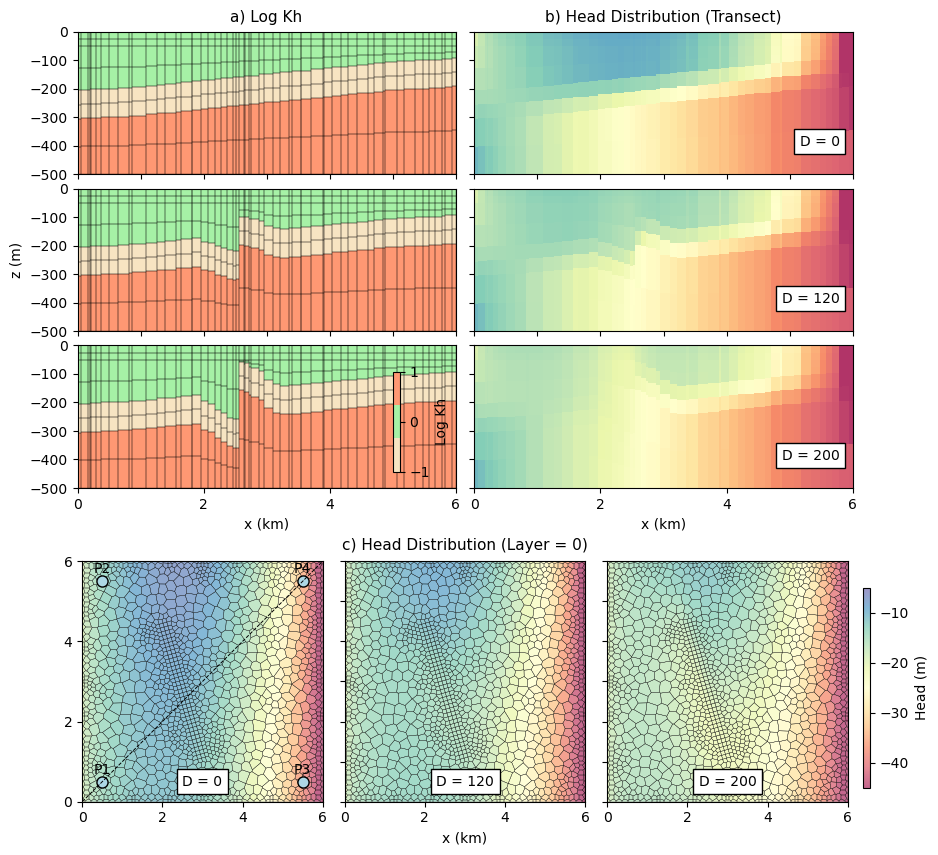

In [7]:
figure6(P, models = fault_models, X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1,vmin = -45, vmax = -5)

### Pinchout - 6 simulations

In [8]:
P.hk = [1, 0.1, 10, 0.1] 
P.vk = [i/10 for i in P.hk]

#P.hk = [1.7, 0.07, 8.2, 0.5] 
#P.vk = [0.12,0.007,0.51,0.05] 

P.cell2dvor, P.xcycvor, P.verticesvor, P.vor, vornodes = createcell2d(P, grid = 'vor', fault = False)    
data = pd.read_excel("../data/loop_showcase_data.xls",sheet_name = "pinchout_example")
strat = pd.read_excel("../data/loop_showcase_data.xls",sheet_name = "strat")

options = np.linspace(-250, 0, 6) # control point z values

pinchout_modelnames, pinchout_models, pinchout_obs_heads = [],[],[]        
heads = []

for i in range(len(options)):
    pinchout_modelnames.append(str('PO_'+str(options[i])))  
    pinchout_models.append(Model(pinchout_modelnames[i], P, plan = 'vor', transect = 'con')) # Create flow model  
    P.control_points = (['CP1', 'control', 3000, 3000, options[i], -200, 'c', 'lower', np.nan, np.nan, np.nan],) 
    
    P.data, P.strat = functions.prepare_geomodel_loopshowcase(P, data, strat, include_fault = False)   # Prepare geomodel inputs
    P.geomodel = functions.create_geomodel_loopshowcase(P, include_fault = False) # Make geomodel
    M = pinchout_models[i]
    M.create_lith_dis_arrays(P)                                 # Create lith and dis arrays
    M.create_prop_arrays(P)                                     # Create K arrays
    M.create_flow_package_arrays(P)                             # Create flow packages
    results = M.write_run_model(P, period = 'Steady', ic_array = P.strt)   
    M.gwf, M.head_ss, M.obs_ss, M.runtime_ss = results[0], results[1], results[2], results[-1]
    pinchout_obs_heads.append((functions.process_obs_steady(P, M)))
    heads.append((M.head_ss))
    f = os.path.join(vtk_workspace, "pinchouts", M.modelname)
    M.gwf.export(f, fmt="vtk")
    


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating lithology and discretisation arrays for  PO_-250.0  ...
   Creating property arrays for  PO_-250.0  ...
   Adding flow packages to  PO_-250.0  ...
   Time taken =  0.923928
   Writing simulation and gwf for  PO_-250.0  ...
Period =  Steady 
   Model success =  True
   run_time =  9.965699


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating lithology and discretisation arrays for  PO_-200.0  ...
   Creating property arrays for  PO_-200.0  ...
   Adding flow packages to  PO_-200.0  ...
   Time taken =  0.734145
   Writing simulation and gwf for  PO_-200.0  ...
Period =  Steady 
   Model success =  True
   run_time =  7.056862


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating lithology and discretisation arrays for  PO_-150.0  ...
   Creating property arrays for  PO_-150.0  ...
   Adding flow packages to  PO_-150.0  ...
   Time taken =  0.663025
   Writing simulation and gwf for  PO_-150.0  ...
Period =  Steady 
   Model success =  True
   run_time =  6.609029


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating lithology and discretisation arrays for  PO_-100.0  ...
   Creating property arrays for  PO_-100.0  ...
   Adding flow packages to  PO_-100.0  ...
   Time taken =  1.033059
   Writing simulation and gwf for  PO_-100.0  ...
Period =  Steady 
   Model success =  True
   run_time =  6.359672


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating lithology and discretisation arrays for  PO_-50.0  ...
   Creating property arrays for  PO_-50.0  ...
   Adding flow packages to  PO_-50.0  ...
   Time taken =  0.622393
   Writing simulation and gwf for  PO_-50.0  ...
Period =  Steady 
   Model success =  True
   run_time =  6.159406


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating lithology and discretisation arrays for  PO_0.0  ...
   Creating property arrays for  PO_0.0  ...
   Adding flow packages to  PO_0.0  ...
   Time taken =  0.586487
   Writing simulation and gwf for  PO_0.0  ...
Period =  Steady 
   Model success =  True
   run_time =  5.747961


In [9]:
#plot_bylayer(P, models = pinchout_models, layer = 1, vmin = -40, vmax = 20) 
#plot_observations(ylim = [-40, 20], modelnames = pinchout_modelnames, heads = pinchout_obs_heads)
#multiplot_vgrid_transect(P, models = pinchout_models, array = 'lith', X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1,)
#multiplot_prop_transect(P, models = pinchout_models, array = 'head_ss', 
                        #X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1, vmin = -45, vmax = 10)

C:\Users\19904604\AppData\Local\Temp\ipykernel_28160\1981077455.py:137: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
C:\Users\19904604\AppData\Local\Temp\ipykernel_28160\1981077455.py:137: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


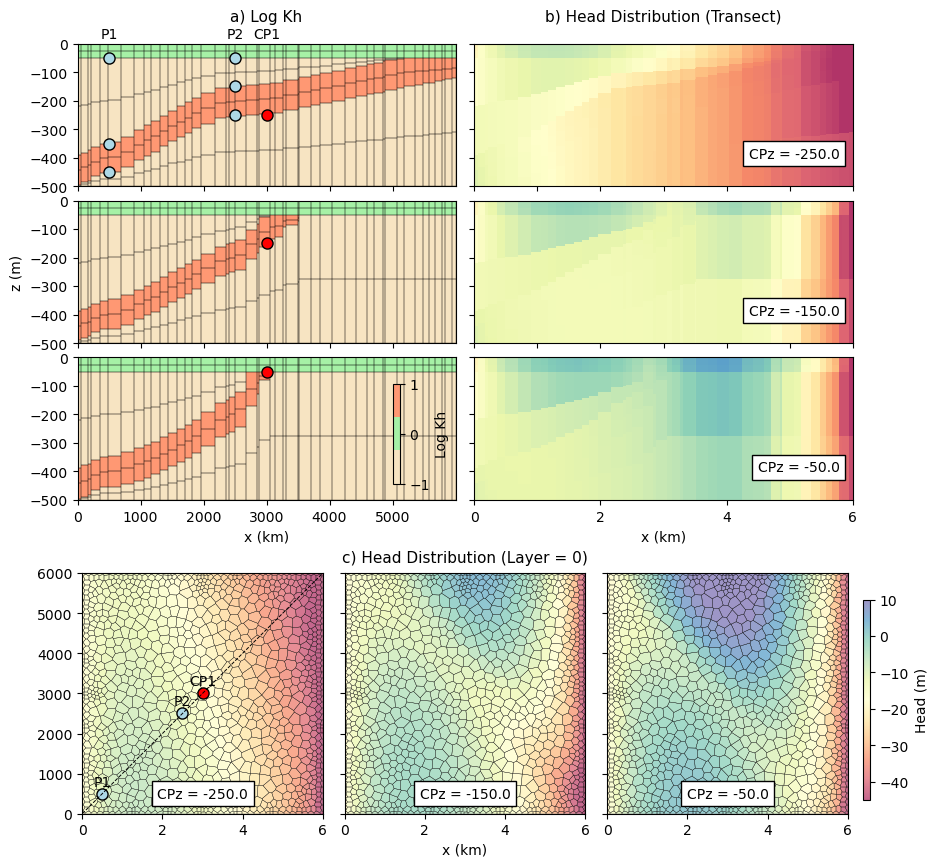

In [10]:
figure5(P, models = pinchout_models, X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1,)

### Pinchout - 100 simulations

In [21]:
options = np.linspace(-250, 0, 100) # control point z values
    
heads_PO = []
for i in range(len(options)): 
    print(i)
    M = Model('PO', P, plan = 'vor', transect = 'con') # Create flow model  
    P.control_points = (['CP1', 'control', 3000, 3000, options[i], -200, 'c', 'lower', np.nan, np.nan, np.nan],) 
    P.data, P.strat = functions.prepare_geomodel_loopshowcase(P, data, strat, include_fault = False)   # Prepare geomodel inputs
    P.geomodel = functions.create_geomodel_loopshowcase(P, include_fault = False) # Make geomodel
    M.create_lith_dis_arrays(P)                                 # Create lith and dis arrays
    M.create_prop_arrays(P)                                     # Create K arrays
    M.create_flow_package_arrays(P)                             # Create flow packages
    results = M.write_run_model(P, period = 'Steady', ic_array = P.strt)  
    M.gwf, M.head_ss, M.obs_ss, M.runtime_ss = results[0], results[1], results[2], results[-1]
    heads_PO.append((M.head_ss))


0
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.639875
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  8.176021
1
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.630359
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  8.463905
2
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.646004
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  8.157882
3
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.639129
   Writing simulation and gwf for  PO  ...
Period =  Steady 
   Model success =  True


   run_time =  8.757305
4
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.782166
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  7.704815
5
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.616072
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  7.807189
6
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.684234
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  8.359123
7
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.608669
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  7.415578
8
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.612286
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  7.087691
9
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.641106
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  9.866758
10
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.628963
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  7.347174
11
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.733483
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  7.142496
12
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.690207
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  7.478597
13
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.619469
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  7.48822
14
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.620605
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  7.565809
15
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.65522
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  6.896455
16
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.59865
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  7.152511
17
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.616685
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  7.690087
18
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.644431
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  7.450648
19
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.633775
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  7.006833
20
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.632497
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  6.788742
21
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.651883
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  6.9378
22
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.623841
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  7.232529
23
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.592949
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  6.709827
24
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.604552
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  6.968828
25
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.602651
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  6.611264
26
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.802506
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  7.191167
27
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.591637
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  6.619874
28
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.776826
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  6.290887
29
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.710457
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  6.653068
30
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.871508
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  6.581494
31
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.648636
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  7.077447
32
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.659287
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  6.672778
33
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.601755
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  5.958404
34
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.606968
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  6.599186
35
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.641769
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  6.824897
36
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.786782
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  6.351976
37
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.637885
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  6.443358
38
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.620982
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  6.085101
39
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.661442
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  6.955797
40
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.662486
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  6.372031
41
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.639328
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  6.695021
42
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.87295
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  8.466724
43
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.734473
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  7.589154
44
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.971075
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  7.713091
45
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.851186
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  7.924677
46
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.840116
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  8.074557
47
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.889541
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  7.572511
48
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.840171
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  9.096345
49
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.820349
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  7.85693
50
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  1.052396
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  7.824118
51
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.690811
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  9.104732
52
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  1.162091
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  9.337036
53
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  1.018355
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  14.091538
54
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.66773
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  7.023173
55
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.659433
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  6.313814
56
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.593414
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  6.839553
57
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.669333
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  6.051713
58
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.660698
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  6.63714
59
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.599349
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  6.678757
60
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.702288
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  7.443162
61
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.860629
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  8.950251
62
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.871751
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  8.102105
63
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  1.067693
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  6.725703
64
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.649249
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  6.388472
65
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.695071
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  6.109459
66
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.772339
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  9.476902
67
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.614719
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  5.652181
68
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.644479
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  5.850893
69
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.614891
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  5.773223
70
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.655908
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  5.824991
71
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.617883
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  5.885248
72
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.620958
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  5.373154
73
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.661633
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  6.237265
74
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.647775
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  5.709618
75
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.624483
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  6.683388
76
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.633926
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  5.898189
77
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.606651
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  5.811047
78
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.624224
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  5.79613
79
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.62922
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  6.36508
80
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.632123
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  5.597481
81
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.639252
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  5.97438
82
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.629207
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  5.734041
83
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.596791
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  5.781307
84
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.600441
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  5.566375
85
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.602623
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  5.421878
86
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.590982
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  5.354712
87
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.60255
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  5.359842
88
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.600553
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  5.490928
89
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.592744
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  5.114427
90
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.719598
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  6.11976
91
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.761311
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  6.333592
92
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.785025
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  6.936878
93
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.782235
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  8.644131
94
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.975317
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  7.456173
95
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.769986
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  7.119648
96
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.740751
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  7.156873
97
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.592006
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  5.473519
98
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.601513
   Writing simulation and gwf for  PO  ...


Period =  Steady 
   Model success =  True
   run_time =  5.371754
99
   Creating lithology and discretisation arrays for  PO  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  PO  ...
   Adding flow packages to  PO  ...
   Time taken =  0.604726
   Writing simulation and gwf for  PO  ...
Period =  Steady 
   Model success =  True
   run_time =  5.394622


In [22]:
layer = 0

stacked = []
for n in range(100):
    heads_disv = -1e30 * np.ones_like(M.idomain, dtype=float) 
    for i, h in enumerate(heads_PO[n][0][0]):
        if math.isnan(h) == False: 
            heads_disv[M.cellid_disu==i] = h        
    stacked.append(heads_disv[layer])
std_PO = np.std(np.array(stacked), axis = 0)

### Fault - 100 realisations

In [23]:
P.cell2dvor, P.xcycvor, P.verticesvor, P.vor, vornodes = createcell2d(P, grid = 'vor', fault = True)  
P.hk = [1, 2, 0.01, 5] 
P.vk = [i/10 for i in P.hk]

options = np.linspace(0, 200, 100) # Fault displacement

data = pd.read_excel("../data/loop_showcase_data.xls",sheet_name = "fault_example")
strat = pd.read_excel("../data/loop_showcase_data.xls",sheet_name = "strat")

P.control_points = ([])
P.fault_max_disp = 100.    # Was 200
P.minor_axis = 1000        # Fault_influence - orthogonal to fault
P.fault_center = [P.fx1 + (P.fx2 - P.fx1)/2, P.fy1 + (P.fy2 - P.fy1)/2, -400]
P.fault_slip_vector=[0,0,1]
        
heads_FD = []
for i in range(len(options)):
    print(i)
    N = Model('FD', P, plan = 'vor', transect = 'con') # Create flow model  
    P.fault_max_disp = options[i]
    P.data, P.strat = functions.prepare_geomodel_loopshowcase(P, data, strat, include_fault = True)   # Prepare geomodel inputs
    P.geomodel = functions.create_geomodel_loopshowcase(P, include_fault = True) # Make geomodel
    N.create_lith_dis_arrays(P)                                 # Create lith and dis arrays
    N.create_prop_arrays(P)                                     # Create K arrays
    N.create_flow_package_arrays(P)                             # Create flow packages
    results = N.write_run_model(P, period = 'Steady', ic_array = P.strt)  
    N.gwf, N.head_ss, N.obs_ss, N.runtime_ss = results[0], results[1], results[2], results[-1]
    heads_FD.append(N.head_ss)


                          projected onto fault surface estimating from fault normal


0
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.755928
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  8.81675
1
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.794599
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  10.08731
2
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.74694
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  9.057813
3
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  1.048814
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  9.49667
4
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.918376
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  9.560138
5
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.832078
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  9.089197
6
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.847137
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  9.143046
7
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.956121
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  9.61462
8
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.75465
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  9.240005
9
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.797106
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  9.372513
10
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  1.004411
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  9.882588
11
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.781921
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  9.056771
12
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.972936
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  9.535092
13
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.800617
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  9.255831
14
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.785389
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  9.727412
15
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.863596
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  9.324334
16
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.829289
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  9.28869
17
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  1.161649
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  10.393499
18
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.811748
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  10.219605
19
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.780142
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  9.016153
20
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  1.368019
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  11.135589
21
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  1.138581
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  10.233475
22
Fault included!


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating lithology and discretisation arrays for  FD  ...
   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.794071
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  9.460733
23
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.783563
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  9.279322
24
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.780286
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  9.677508
25
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.747544
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  9.17383
26
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.772623
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  9.84303
27
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.78497
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  9.658201
28
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.833458
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  9.130908
29
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.759438
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  9.961428
30
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.733239
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  9.071509
31
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.725926
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  8.907451
32
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.729709
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  8.821463
33
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.721478
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  8.962665
34
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.734758
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  9.202194
35
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.725347
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  8.892868
36
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.732052
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  9.300679
37
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.729386
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  8.722248
38
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.804303
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  8.739839
39
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.729422
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  8.69937
40
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.731193
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  8.772935
41
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.719997
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  9.300526
42
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.720301
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  12.221179
43
Fault included!


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating lithology and discretisation arrays for  FD  ...
   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.772271
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  9.376954
44
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.783891
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  8.974335
45
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.729707
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  8.65984
46
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.713085
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  8.748146
47
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.895337
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  8.600441
48
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.711294
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  8.63747
49
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.730853
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  8.684359
50
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.694312
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  8.823408
51
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.955029
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  9.767906
52
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.892684
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  8.835826
53
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.719241
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  9.193276
54
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.754473
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  10.572279
55
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.712558
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  8.546945
56
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.721897
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  8.450606
57
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.894006
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  8.527302
58
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.721049
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  8.725697
59
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.717713
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  8.755875
60
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.700352
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  8.515445
61
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.708206
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  8.691907
62
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.886751
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  9.067736
63
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.722686
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  8.714148
64
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.712539
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  8.589626
65
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.719058
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  8.499719
66
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.71352
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  8.760849
67
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.716564
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  8.620542
68
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.715821
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  8.592255
69
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.708303
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  8.711878
70
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.731008
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  9.285473
71
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.722304
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  8.733153
72
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.718714
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  8.533868
73
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.71356
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  9.365969
74
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.881191
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  8.600028
75
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.891369
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  10.53134
76
Fault included!


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating lithology and discretisation arrays for  FD  ...
   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.703641
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  8.733868
77
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.757861
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  10.559312
78
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.83447
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  10.860532
79
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.981378
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  9.439899
80
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.78869
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  9.461727
81
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.784986
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  9.754257
82
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.945191
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  11.02456
83
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.957399
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  9.586904
84
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.808574
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  9.687386
85
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.793677
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  9.705807
86
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.79495
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  10.424468
87
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  1.01535
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  10.449699
88
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.903531
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  10.21268
89
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.723312
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  8.306574
90
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.71206
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  8.610783
91
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.996421
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  8.887831
92
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.713785
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  8.980616
93
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.712513
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  9.185721
94
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.710025
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  8.519146
95
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.691279
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  8.500455
96
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.710786
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  8.58064
97
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.700809
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  8.54014
98
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.695127
   Writing simulation and gwf for  FD  ...


                          projected onto fault surface estimating from fault normal


Period =  Steady 
   Model success =  True
   run_time =  8.70361
99
Fault included!
   Creating lithology and discretisation arrays for  FD  ...


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   Creating property arrays for  FD  ...
   Adding flow packages to  FD  ...
   Time taken =  0.734009
   Writing simulation and gwf for  FD  ...
Period =  Steady 
   Model success =  True
   run_time =  8.585491


In [24]:
# FAULT
stacked = []
for n in range(100):
    heads_disv = -1e30 * np.ones_like(N.idomain, dtype=float) 
    for i, h in enumerate(heads_FD[n][0][0]):
        if math.isnan(h) == False: 
            heads_disv[N.cellid_disu==i] = h        
    stacked.append(heads_disv[layer])
std_FD = np.std(np.array(stacked), axis = 0)

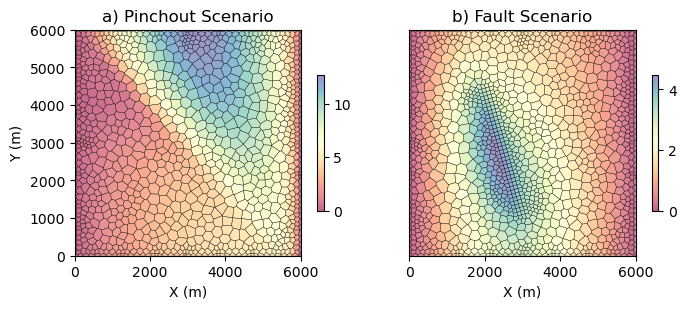

In [25]:
figure7(P, std_PO, std_FD)

In [26]:
max(heads_FD[0][0][0] - heads_FD[99][0][0])

np.float64(12.846893823648863)